In [73]:
from torch_geometric.nn import GAE, GCNConv
from torch.nn import MSELoss
from torch.optim import Adam
import torch
import matplotlib.pyplot as plt
import networkx as ntx
import numpy as np

In [149]:
class GCNEncoder(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, out_dim):
            torch.random.manual_seed(37)
            super(GCNEncoder, self).__init__()
            self.conv1 = GCNConv(input_dim, hidden_dim, cached=True)  # cached only for transductive learning
            self.conv2 = GCNConv(hidden_dim, out_dim, cached=True)    # cached only for transductive learning

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index).relu()
            return self.conv2(x.float(), edge_index).relu()

In [196]:
class GCNDecoder(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, out_dim):
            torch.random.manual_seed(37)
            super(GCNDecoder, self).__init__()
            self.conv1 = GCNConv(out_dim, hidden_dim, cached=True)  # cached only for transductive learning
            self.conv2 = GCNConv(hidden_dim, input_dim, cached=True)    # cached only for transductive learning

        def forward(self, x, edge_index, sigmoid=[]):
            x = self.conv1(x, edge_index).relu()
            return self.conv2(x.float(), edge_index).relu()

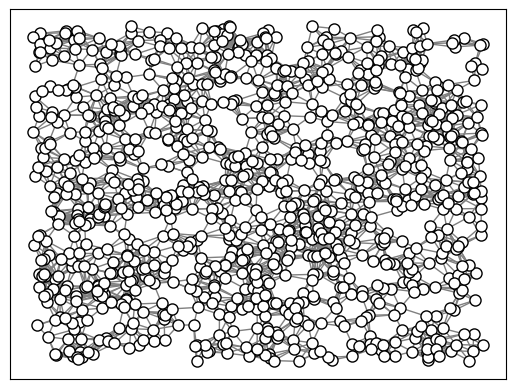

In [197]:
'''
Grafo: N pontos aleatórios dentro da caixa [0,1] x [0,1]
'''

''' Parâmetros '''
### Grafo ###
N = 1000 # Número de vértices no grafo
edge_sigma = 0.1 # Sigma da expressão que define os pesos das arestas
edge_min_weight = 0.85 # Limiar de peso (abaixo disso é anulado)

def all_distances(M):
    N,D = M.shape
    lins = np.tile(M.reshape((N,1,D)),(1,N,1))
    cols = np.tile(M.reshape((1,N,D)),(N,1,1))
    return np.sum((lins-cols)**2,axis=2)**0.5

# Node Positions
N_pos = np.random.random((N,2))*2-1

# Matriz Adjacência
A = np.exp(-all_distances(N_pos)**2/edge_sigma) - np.eye(N)
A[A<edge_min_weight] = 0
G = ntx.from_numpy_array(A)
N_pos = (N_pos+1)/2

plt.figure()
ntx.draw_networkx_edges(G, pos=N_pos, edge_color='gray', alpha=1)
for n in range(N): plt.plot(N_pos[n,0],N_pos[n,1],'ok',markerfacecolor='w',markersize=8)
plt.axis(np.array([-0.05, 1.05, -0.05, 1.05]))
plt.show()

In [198]:
lins, cols = np.where(A!=0)
num_edges = lins.shape[0]
edge_index = torch.zeros((2,num_edges), dtype=int)
edge_index[0,:] = torch.tensor(lins)
edge_index[1,:] = torch.tensor(cols)
edge_index

tensor([[  0,   0,   0,  ..., 999, 999, 999],
        [679, 699, 728,  ..., 645, 751, 770]])

In [199]:
X = torch.cat( (torch.tensor(N_pos),torch.tensor(N_pos)) , axis=1 )
X

tensor([[0.3574, 0.1111, 0.3574, 0.1111],
        [0.2986, 0.9802, 0.2986, 0.9802],
        [0.0756, 0.2272, 0.0756, 0.2272],
        ...,
        [0.5193, 0.7640, 0.5193, 0.7640],
        [0.4980, 0.0400, 0.4980, 0.0400],
        [0.4389, 0.8481, 0.4389, 0.8481]], dtype=torch.float64)

In [200]:
input_dim = X.shape[1]
out_dim = 2
hidden_dim = int( (input_dim+out_dim)/2 )

encoder = GCNEncoder(input_dim, hidden_dim, out_dim)
decoder = GCNDecoder(input_dim, hidden_dim, out_dim)
model = GAE(encoder,decoder)
model

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(4, 3)
    (conv2): GCNConv(3, 2)
  )
  (decoder): GCNDecoder(
    (conv1): GCNConv(2, 3)
    (conv2): GCNConv(3, 4)
  )
)

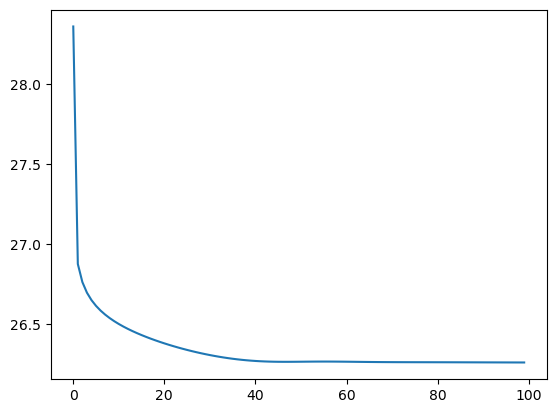

In [201]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features = X.to(device).float()
edge_index = edge_index.to(device)
model = model.to(device)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(features, edge_index)
    loss = model.recon_loss(z, edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

num_epochs = 100
losses = []
for epoch in range(1, num_epochs+1):
    loss = train()
    losses.append(loss)

plt.plot(losses)

In [202]:
X

tensor([[0.3574, 0.1111, 0.3574, 0.1111],
        [0.2986, 0.9802, 0.2986, 0.9802],
        [0.0756, 0.2272, 0.0756, 0.2272],
        ...,
        [0.5193, 0.7640, 0.5193, 0.7640],
        [0.4980, 0.0400, 0.4980, 0.0400],
        [0.4389, 0.8481, 0.4389, 0.8481]], dtype=torch.float64)

In [203]:
z = model.encoder(features,edge_index)
z

tensor([[0.4159, 0.0000],
        [0.4695, 0.0000],
        [0.3503, 0.0000],
        ...,
        [0.6276, 0.0000],
        [0.5910, 0.0000],
        [0.5375, 0.0000]], grad_fn=<ReluBackward0>)

In [212]:
X_rec = model.decoder(z,edge_index)
X_rec

tensor([[0.0000, 0.3251, 0.0000, 0.0000],
        [0.0000, 0.3744, 0.0000, 0.0000],
        [0.0000, 0.3457, 0.0000, 0.0000],
        ...,
        [0.0000, 0.4943, 0.0000, 0.0000],
        [0.0000, 0.4845, 0.0000, 0.0000],
        [0.0000, 0.4179, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)

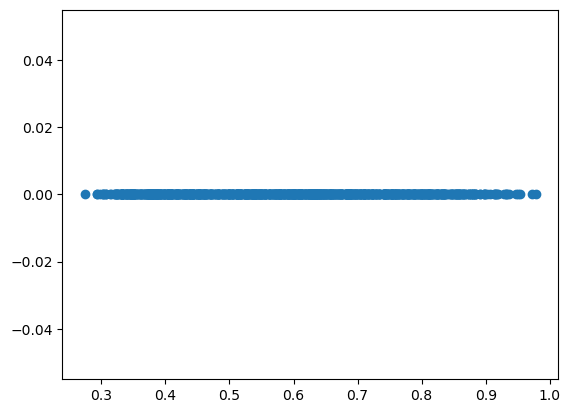

In [210]:
plt.scatter(z.detach().numpy()[:,0],z.detach().numpy()[:,1])

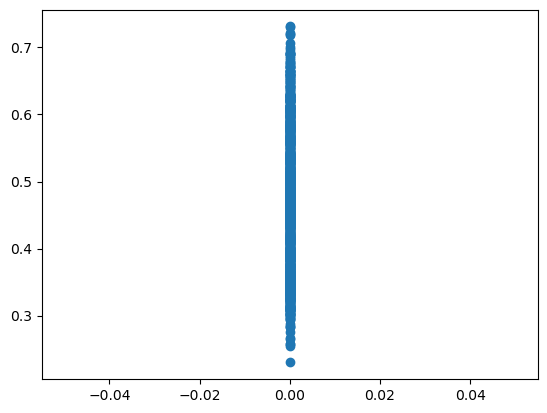

In [215]:
plt.scatter(X_rec.detach().numpy()[:,3],X_rec.detach().numpy()[:,1])